# Machine Learning for phase transition recognition in Ising model using autocorrelation

In this notebook I evaluated the performance of a neural network to recognize phase transition in the ising model.

First I tried with a simply recognition task then I proceeded with a prediction task and finally I analysed the autocorrelation of the output layer.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import scipy.io as sio
import time

For ising data I used a montecarlo simulation temperature dependent, created by me on the HPC cluster of Unipr

In [3]:
data = sio.loadmat('./HPC/Session.mat')

## Training for phase recognition

Firs set up the datas

In [5]:
perc = 0.15 
p = numpy.random.permutation(50000)
training = data['train_lim_out_data']
output = data['output_2_lim']
testing = data['test_out_data']
training = training[p]
output = output[p]
validation = training[:round(perc*len(training)),:]
output_validation = output[:round(perc*len(training)),:]
output_training = output[round(perc*len(training)):,:]
training = training[round(perc*len(training)):,:]

In [6]:
print(training.shape)
print(output_training.shape)
print(validation.shape)
print(output_validation.shape)

(42500, 900)
(42500, 2)
(7500, 900)
(7500, 2)


Let's print the result of the montacarlo simulation of magnetization/temperature

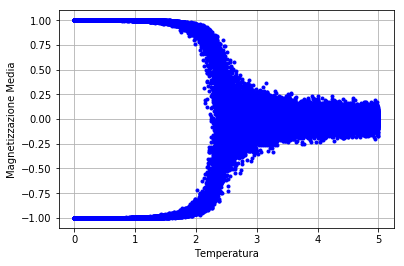

In [7]:
X = data['train_lim_T']
Y = data['train_lim_out_magn']
plot(X,Y,'b.');
xlabel('Temperatura')
grid()
ylabel('Magnetizzazione Media')
savefig('Magnetizzazione_lim.pdf', bbox_inches='tight')

Now it's time for neural network, despite the current state of art I used a very simple neural network composed by only one hidden layer. 

The lattice used for montecarlo simulaton is 30x30 so the input layer is 900 and the hidden layer is 100.

The output layer is composed by only 2 neurons. 

For training the network I used the whole set of temperature data signed manually set to [1,0] if the state is high or [0,1] if the state is low. This distinction is given by theory, so I want to try if a neural network is capable of understand if the lattice is high or low. 

I used cross entropy error with SGD for error minimizing. To avoid overfitting I used L2 regularization and early stopping.

In [8]:
# Parameters
learning_rate = 0.2
check_validation = 3
batch_size = 10
max_iteration = 30
l = 15.0

# tf Graph Input and Output
x = tf.placeholder(tf.float32, [None, 900], name='x') #input layer 
y = tf.placeholder(tf.float32, [None, 2], name='y')   #output layer

def Net(x,weights,biases):
    out = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
    out = tf.add(tf.matmul(out, weights['w2']), biases['b2'])
    return out

# Set model weights
weights = {
    'w1': tf.Variable(tf.random_normal([900, 100]),name='w1'),
    'w2': tf.Variable(tf.random_normal([100, 2]),name='w2'),
}
biases = {
    'b1': tf.Variable(tf.random_normal([100]),name='b1'),
    'b2': tf.Variable(tf.random_normal([2]),name='b2'),
}

out = Net(x, weights, biases)

# Minimize error using cross entropy
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=out))
regularizer_1 = tf.nn.l2_loss(weights['w1'])
regularizer_2 = tf.nn.l2_loss(weights['w2'])
cost = tf.reduce_mean(cost + l/90200 * (tf.add(regularizer_1,regularizer_2)))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_out = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_out, tf.float32))


# Initializing the variables
init = tf.global_variables_initializer()

# Tensorboard
#tf.summary.histogram('w1',weights['w1'])
#tf.summary.histogram('w2',weights['w2'])
#tf.summary.histogram('b1',biases['b1'])
#tf.summary.histogram('b2',biases['b2'])
#tf.summary.scalar('cost',cost)
#tf.summary.scalar('accuracy',accuracy)
#merge = tf.summary.merge_all()

In [9]:
with tf.Session() as sess:
    #Tensorboard
    #train_writer = tf.summary.FileWriter('./logs/lim_train',sess.graph,flush_secs=10)
    saver = tf.train.Saver()
    sess.run(init)
    step = 0
    loss, acc = sess.run([cost, accuracy], feed_dict={x: training,\
                                                      y: output_training})
    loss2, acc2 = sess.run([cost, accuracy], feed_dict={x: validation,\
                                                        y: output_validation})
    print ("Iter " + str(step) + ", Cost= " + \
               "{:.5f}".format(loss) + ", Training Accuracy= " + \
               "{:.5f}".format(acc) + ", Validation Accuracy= " + \
               "{:.5f}".format(acc2))

    j = 0
    best_acc = acc2
    # Keep training until reach max iterations
    while step < max_iteration:
        
        #shuffle data
        p = numpy.random.permutation(len(training))
        training = training[p]
        output_training = output_training[p]
        
        for i in range(len(training)//batch_size):
        
            batch_x = training[i*batch_size:(i+1)*batch_size]
            batch_y = output_training[i*batch_size:(i+1)*batch_size]
            
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        # TensorBoard
        #summary,loss, acc = sess.run ([merge, cost, accuracy], feed_dict={x: training,\
        #                                                                  y: output_training})
        #train_writer.add_summary(summary, step+1)
        
        loss, acc = sess.run ([ cost, accuracy], feed_dict={x: training,\
                                                            y: output_training})

        
        loss2, acc2 = sess.run([cost, accuracy], feed_dict={x: validation,\
                                                            y: output_validation})
        
        print ("Iter " + str(step+1) + ", Cost= " + \
                   "{:.5f}".format(loss) + ", Training Accuracy= " + \
                   "{:.5f}".format(acc) + ", Validation Accuracy= " + \
                   "{:.5f}".format(acc2))
        
        if acc2 > best_acc:
            j = 0
            best_acc = acc2
            saver.save(sess,'./Tensorflow_lim_model/lim_model')
        else: j+=1
        
        if j == check_validation: 
            print('Check Validation Reached')
            break
        step += 1
    
    if step == max_iteration: print('Max Iterations Reached')

Iter 0, Cost= 9.93378, Training Accuracy= 0.48120, Validation Accuracy= 0.47107
Iter 1, Cost= 5.95698, Training Accuracy= 0.85800, Validation Accuracy= 0.83813
Iter 2, Cost= 4.52426, Training Accuracy= 0.88412, Validation Accuracy= 0.84920
Iter 3, Cost= 3.32506, Training Accuracy= 0.95652, Validation Accuracy= 0.92213
Iter 4, Cost= 2.49217, Training Accuracy= 0.97499, Validation Accuracy= 0.94107
Iter 5, Cost= 1.87481, Training Accuracy= 0.98518, Validation Accuracy= 0.95373
Iter 6, Cost= 1.41353, Training Accuracy= 0.99153, Validation Accuracy= 0.96680
Iter 7, Cost= 1.06651, Training Accuracy= 0.99532, Validation Accuracy= 0.97453
Iter 8, Cost= 0.81041, Training Accuracy= 0.99562, Validation Accuracy= 0.98027
Iter 9, Cost= 0.61738, Training Accuracy= 0.99708, Validation Accuracy= 0.98360
Iter 10, Cost= 0.47731, Training Accuracy= 0.99595, Validation Accuracy= 0.98440
Iter 11, Cost= 0.36350, Training Accuracy= 0.99751, Validation Accuracy= 0.98760
Iter 12, Cost= 0.27791, Training Accur

### Testing 

Let's see what the network has learned

In [10]:
out = tf.sigmoid(out)

In [11]:
with tf.Session() as sess:
    saver.restore(sess,'./Tensorflow_lim_model/lim_model')
    sess.run(init)
    ext = zeros([150,2])
    for i in range(testing.shape[0]):
        ext[i,:] = sess.run(out, feed_dict={x: reshape(array(testing[i,:,0]),(1,900))})

INFO:tensorflow:Restoring parameters from ./Tensorflow_lim_model/lim_model


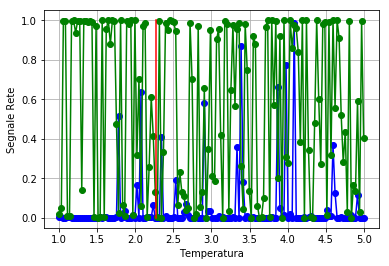

In [12]:
X = data['test_T']
plot(X.ravel(),ext[:,0],'b-o')
plot(X.ravel(),ext[:,1],'g-o')
vec = linspace(0,1,100)
plot(ones((1,100)).ravel()*2/log(1+sqrt(2)),vec,'r')
grid()
xlabel('Temperatura')
ylabel('Segnale Rete')
savefig('Segnale_singolo.pdf', bbox_inches='tight')

Not so good as I expected. The problem is that you can't use only a single test simulation but you need to average the output signal of the network.

In [13]:
with tf.Session() as sess:
    saver.restore(sess,'./Tensorflow_lim_model/lim_model')
    avg_lim = zeros([150,2])
    for i in range(150):
        value = zeros([1000,2])
        for j in range(testing.shape[2]):
            value[j,:]=sess.run(out, feed_dict={x: reshape(array(testing[i,:,j]),(1,900))})
        avg_lim[i,:]=(mean(value,axis=0))

INFO:tensorflow:Restoring parameters from ./Tensorflow_lim_model/lim_model


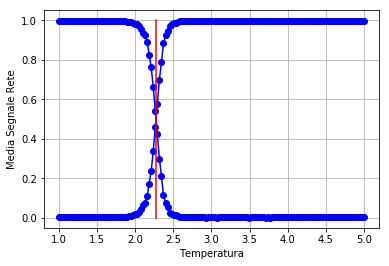

In [28]:
X = data['test_T']
plot(X.ravel(),avg_lim[:,0],'b-o')
plot(X.ravel(),avg_lim[:,1],'b-o')
vec = linspace(0,1,100)
plot(ones((1,100)).ravel()*2/log(1+sqrt(2)),vec,'r')
grid()
xlabel('Temperatura')
ylabel('Media Segnale Rete')
savefig('Segnale_lim.pdf', bbox_inches='tight')

Now let's do a fit

[ 4.09363332 -8.80016053]
[-4.09181563  9.79556069]


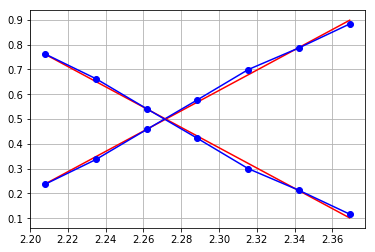

In [17]:
from scipy.optimize import curve_fit

def func(x, a, b):
     return (a * x) + b

popt1, pcov = curve_fit(func, X.ravel()[45:52], avg_lim[45:52,0])
plot(X.ravel()[45:52], func(X.ravel()[45:52], *popt1), 'r-')
plot(X.ravel()[45:52], avg_lim[45:52,0],'b-o')
print(popt1)

popt2, pcov = curve_fit(func, X.ravel()[45:52], avg_lim[45:52,1])
plot(X.ravel()[45:52], func(X.ravel()[45:52], *popt2), 'r-')
plot(X.ravel()[45:52], avg_lim[45:52,1],'b-o')
print(popt2)
grid()

In [18]:
pred = (popt2[1]-popt1[1])/(popt1[0]-popt2[0])
value = 2/log(1+sqrt(2))
print(pred)
print(value)
print(abs(pred-value))

2.271802235393986
2.269185314213022
0.002616921180964127


The first value is the predicted value of the network, the second is the teoretical value and the third is the difference between the twos.

Good but we can do more, because you have set the value for high or low manually based on theory so let's try to predict the value but with less data.



## Training for Prediction

In [19]:
perc = 0.15
p = numpy.random.permutation(50000)
training = data['train_ext_out_data']
output = data['output_2_ext']
testing = data['test_out_data']
training = training[p]
output = output[p]
validation = training[:round(perc*len(training)),:]
output_validation = output[:round(perc*len(training)),:]
output_training = output[round(perc*len(training)):,:]
training = training[round(perc*len(training)):,:]

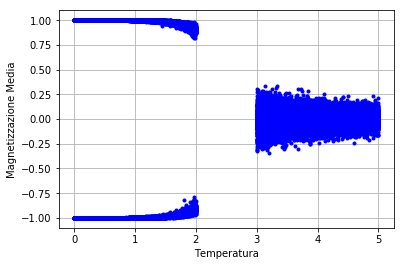

In [20]:
X = data['train_ext_T']
Y = data['train_ext_out_magn']
plot(X,Y,'b.');
grid()
xlabel('Temperatura')
ylabel('Magnetizzazione Media')
savefig('Magnetizzazione_ext.pdf', bbox_inches='tight')

As you can see from the image the middle values has been eliminated

For training, datas with temperature lower than 2 has set with high ([1,0]) and the other with ([0,1])

In [21]:
# Parameters
learning_rate = 0.3
check_validation = 2
batch_size = 10
max_iteration = 10
l = 15.0

# tf Graph Input and Output
x = tf.placeholder(tf.float32, [None, 900], name='x') 
y = tf.placeholder(tf.float32, [None, 2], name='y') 

def Net(x,weights,biases):
    out = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
    out = tf.add(tf.matmul(out, weights['w2']), biases['b2'])
    return out

# Set model weights
weights = {
    'w1': tf.Variable(tf.random_normal([900, 100])),
    'w2': tf.Variable(tf.random_normal([100, 2])),
}
biases = {
    'b1': tf.Variable(tf.random_normal([100])),
    'b2': tf.Variable(tf.random_normal([2])),
}

out = Net(x, weights, biases)

# Minimize error using cross entropy
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=out))
regularizer_1 = tf.nn.l2_loss(weights['w1'])
regularizer_2 = tf.nn.l2_loss(weights['w2'])
cost = tf.reduce_mean(cost + l/90200 * (tf.add(regularizer_1,regularizer_2)))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_out = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_out, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [22]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    step = 0
    loss, acc = sess.run([cost, accuracy], feed_dict={x: training,\
                                                      y: output_training})
    loss2, acc2 = sess.run([cost, accuracy], feed_dict={x: validation,\
                                                        y: output_validation})
    print ("Iter " + str(step) + ", Cost= " + \
               "{:.5f}".format(loss) + ", Training Accuracy= " + \
               "{:.5f}".format(acc) + ", Validation Accuracy= " + \
               "{:.5f}".format(acc2))

    j = 0
    best_acc = acc2
    # Keep training until reach max iterations
    while step < max_iteration:
        
        #shuffle data
        p = numpy.random.permutation(len(training))
        training = training[p]
        output_training = output_training[p]
        
        for i in range(len(training)//batch_size):
        
            batch_x = training[i*batch_size:(i+1)*batch_size]
            batch_y = output_training[i*batch_size:(i+1)*batch_size]
            
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        # Calculate batch loss and accuracy
        loss, acc = sess.run([cost, accuracy], feed_dict={x: training,\
                                                          y: output_training})
        loss2, acc2 = sess.run([cost, accuracy], feed_dict={x: validation,\
                                                            y: output_validation})
        
        print ("Iter " + str(step+1) + ", Cost= " + \
                   "{:.5f}".format(loss) + ", Training Accuracy= " + \
                   "{:.5f}".format(acc) + ", Validation Accuracy= " + \
                   "{:.5f}".format(acc2))
        
        if acc2 > best_acc:
            j = 0
            best_acc = acc2
            saver.save(sess,'./Tensorflow_ext_model/ext_model')
        else: j+=1
        
        if j == check_validation: 
            print('Check Validation Reached')
            break
        step += 1
    
    if step == max_iteration: print('Max Iterations Reached')

Iter 0, Cost= 10.27620, Training Accuracy= 0.53967, Validation Accuracy= 0.55120
Iter 1, Cost= 5.45912, Training Accuracy= 0.64720, Validation Accuracy= 0.63760
Iter 2, Cost= 3.25042, Training Accuracy= 0.98186, Validation Accuracy= 0.96827
Iter 3, Cost= 2.08583, Training Accuracy= 0.99951, Validation Accuracy= 0.99267
Iter 4, Cost= 1.36185, Training Accuracy= 1.00000, Validation Accuracy= 0.99680
Iter 5, Cost= 0.89126, Training Accuracy= 1.00000, Validation Accuracy= 0.99920
Iter 6, Cost= 0.58369, Training Accuracy= 1.00000, Validation Accuracy= 0.99987
Iter 7, Cost= 0.38259, Training Accuracy= 1.00000, Validation Accuracy= 1.00000
Iter 8, Cost= 0.25111, Training Accuracy= 1.00000, Validation Accuracy= 1.00000
Iter 9, Cost= 0.16520, Training Accuracy= 1.00000, Validation Accuracy= 1.00000
Check Validation Reached


### Testing

In [23]:
out = tf.sigmoid(out)

In [24]:
start = time.time()

with tf.Session() as sess:
    saver.restore(sess,'./Tensorflow_ext_model/ext_model')
    avg_ext = zeros([150,2])
    for i in range(150):
        value = zeros([1000,2])
        for j in range(testing.shape[2]):
            value[j,:]=sess.run(out, feed_dict={x: reshape(array(testing[i,:,j]),(1,900))})
        avg_ext[i,:]=(mean(value,axis=0))

end = time.time()
print(end - start)

INFO:tensorflow:Restoring parameters from ./Tensorflow_ext_model/ext_model
56.199214935302734


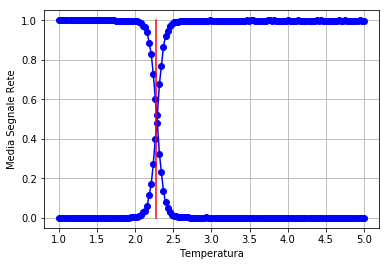

In [25]:
X = data['test_T']
Y = avg_ext
plot(X.ravel(),avg_ext[:,0],'b-o')
plot(X.ravel(),avg_ext[:,1],'b-o')
vec = linspace(0,1,100)
plot(ones((1,100)).ravel()*2/log(1+sqrt(2)),vec,'r')
grid()
xlabel('Temperatura')
ylabel('Media Segnale Rete')
savefig('Segnale_ext.pdf', bbox_inches='tight')

[  4.61165216 -10.0246305 ]
[-4.61218084 11.02634095]


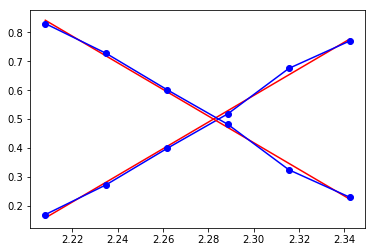

In [26]:
from scipy.optimize import curve_fit

def func(x, a, b):
     return (a * x) + b

popt1, pcov = curve_fit(func, X.ravel()[45:51], avg_ext[45:51,0])
plot(X.ravel()[45:51], func(X.ravel()[45:51], *popt1), 'r-')
plot(X.ravel()[45:51], avg_ext[45:51,0],'b-o')
print(popt1)

popt2, pcov = curve_fit(func, X.ravel()[45:51], avg_ext[45:51,1])
plot(X.ravel()[45:51], func(X.ravel()[45:51], *popt2), 'r-')
plot(X.ravel()[45:51], avg_ext[45:51,1],'b-o')
print(popt2)

In [27]:
pred = (popt2[1]-popt1[1])/(popt1[0]-popt2[0])
value = 2/log(1+sqrt(2))
print(pred)
print(value)
print(abs(pred-value))

2.2822368388192316
2.269185314213022
0.013051524606209508


Not so bad. So the same network trained with less data can predict the value for phase transition.

## Autocorrelation Analysis

In the last section I analysed the autocorrelation signal of the output layer at different temperature.

In [3]:
def AutoCorr(cc,ll):
    
    if len(cc) < (ll-1):
        disp('ciccia...')
        return
    else:
        if len(cc) < 2*ll:
            disp('attenzione! pochi dati ...')

    res = zeros([ll,1])
    
    for i in range(ll):
        res[i] = mean(cc[0:-1-i]*cc[i:-1])

    res = res - mean(cc)**2

    res = res/res[0]
    return res


In [4]:
data = sio.loadmat('./HPC/data_038.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'I', 'L', 'LL', 'Magn', 'bt', 'cc_metro', 'cc_sw', 'exp_metro', 'exp_sw', 'i', 'j', 'magn_metro', 'magn_sw', 'n', 'net_100_2_lim_in'])

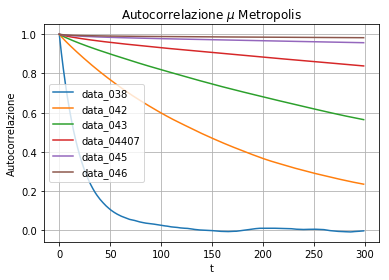

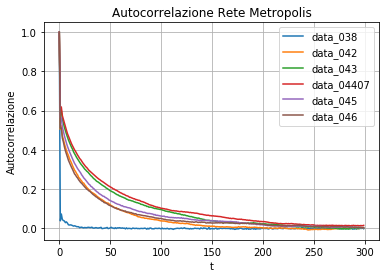

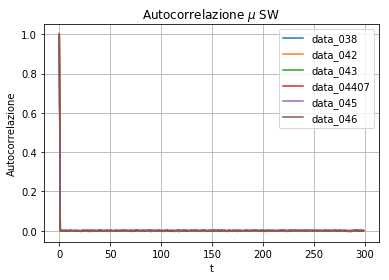

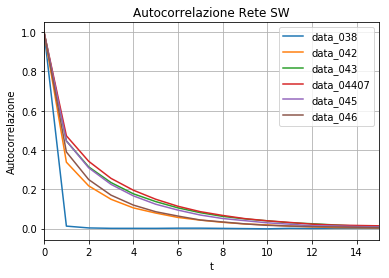

In [5]:

L = 300
#figure(num=1,figsize=(20, 10))
#figure(num=2,figsize=(20, 10))
#figure(num=3,figsize=(20, 10))
#figure(num=4,figsize=(20, 10))

for i in ['data_038','data_042','data_043','data_04407','data_045','data_046']:
    
    cc_metro=zeros([L,3])
    cc_sw=zeros([L,3])
    
    data = sio.loadmat('./HPC/'+i+'.mat')
    magn_metro = data['magn_metro'].ravel()/max(data['magn_metro'].ravel())
    magn_sw = data['magn_sw'].ravel()/max(data['magn_sw'].ravel())
    exp_sw = data['exp_sw']
    exp_metro = data['exp_metro']
    
    cc_metro[:,0]=AutoCorr(magn_metro,L).ravel()
    cc_sw[:,0]=AutoCorr(magn_sw,L).ravel()
    cc_metro[:,1]=AutoCorr(exp_metro[0],L).ravel()
    cc_sw[:,1]=AutoCorr(exp_sw[0],L).ravel()
    #cc_metro[:,2]=AutoCorr(exp_metro[1],L).ravel()
    #cc_sw[:,2]=AutoCorr(exp_sw[1],L).ravel()
    
    figure(1)
    plot(cc_metro[:,0],label=i)

    figure(2)
    plot(cc_metro[:,1],label=i)
    #plot(cc_metro[:,2])

    figure(3)
    plot(cc_sw[:,0],label=i)
    
    figure(4)
    plot(cc_sw[:,1],label=i)
    #plot(cc_sw[:,2])

figure(1)
title('Autocorrelazione $\mu$ Metropolis')
grid()
legend()
xlabel('t')
ylabel('Autocorrelazione')
savefig('Auto_metro_magn.pdf', bbox_inches='tight')
figure(2)
title('Autocorrelazione Rete Metropolis')
grid()
legend()
xlabel('t')
ylabel('Autocorrelazione')
savefig('Auto_metro_rete.pdf', bbox_inches='tight')
figure(3)
title('Autocorrelazione $\mu$ SW')
grid()
legend()
xlabel('t')
ylabel('Autocorrelazione')
savefig('Auto_sw_magn.pdf', bbox_inches='tight')
figure(4)
title('Autocorrelazione Rete SW')
grid()
legend()
xlabel('t')
ylabel('Autocorrelazione')
xlim([0,15]);
savefig('Auto_sw_rete.pdf', bbox_inches='tight')

We have 4 graph of autocorrelation signal of 6 different temperatures (in the legend there is beta which is 1/T)

In the first and the second I used the metropolis algorith for montecarlo simulation which is a local move algorithm so the autocorrelation between moves is strong.

In the last twos I used a different algorithm called swendsen wang (SW) algorith which is a global move algorithm so the autocorrelation between moves is 0.

In the magnetization signal we have a strong signal in metropolis and 0 signal in SW as expected.

The interesting thing comes with the autocorrelation signal of the output layer. We have the higher signal for the phase transition temperature and this behaviour it's not related to the algorithm.